In [1]:
import os
import math

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

from sklearn.svm import SVC

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_semestr_4.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

## Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   studium_id               1616 non-null   int64  
 1   dokoncil_semestr         1616 non-null   float64
 2   BI-PA1_znamka            1616 non-null   float64
 3   BI-PA1_poradi_zapisu     1616 non-null   float64
 4   BI-PAI_znamka            1616 non-null   float64
 5   BI-PAI_poradi_zapisu     1616 non-null   float64
 6   BI-CAO_znamka            1616 non-null   float64
 7   BI-CAO_poradi_zapisu     1616 non-null   float64
 8   BI-PS1_znamka            1616 non-null   float64
 9   BI-PS1_poradi_zapisu     1616 non-null   float64
 10  BI-MLO_znamka            1616 non-null   float64
 11  BI-MLO_poradi_zapisu     1616 non-null   float64
 12  BI-ZMA_znamka            1616 non-null   float64
 13  BI-ZMA_poradi_zapisu     1616 non-null   float64
 14  pocet_kreditu_semestr_1 

In [4]:
matrix_bak.mean()

studium_id                 1.438056e+07
dokoncil_semestr           7.054455e-01
BI-PA1_znamka              2.106436e+00
BI-PA1_poradi_zapisu       1.032797e+00
BI-PAI_znamka              2.054146e+00
BI-PAI_poradi_zapisu       8.743812e-01
BI-CAO_znamka              9.904084e-01
BI-CAO_poradi_zapisu       8.162129e-01
BI-PS1_znamka              2.132116e+00
BI-PS1_poradi_zapisu       1.034653e+00
BI-MLO_znamka              1.833540e+00
BI-MLO_poradi_zapisu       9.356436e-01
BI-ZMA_znamka              2.071473e+00
BI-ZMA_poradi_zapisu       1.052599e+00
pocet_kreditu_semestr_1    2.613800e+01
BI-PA2_znamka              2.345916e+00
BI-PA2_poradi_zapisu       7.970297e-01
BI-DBS_znamka              1.721535e+00
BI-DBS_poradi_zapisu       8.712871e-01
BI-SAP_znamka              1.672958e+00
BI-SAP_poradi_zapisu       8.440594e-01
BI-LIN_znamka              2.850248e+00
BI-LIN_poradi_zapisu       8.898515e-01
pocet_kreditu_semestr_2    2.277970e+01
BI-AAG_znamka              2.334777e+00


## Příprava datasetu

### Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

### Nastavení atributů na kategorické - ordinální

In [6]:
# ordinální
grades_category = pd.api.types.CategoricalDtype(categories=[-1, 1, 1.5, 2, 2.5, 3, 4], ordered=True)
# BI-PA1
matrix_bak['BI-PA1_znamka'] = matrix_bak['BI-PA1_znamka'].astype(grades_category)
# BI-PAI
matrix_bak['BI-PAI_znamka'] = matrix_bak['BI-PAI_znamka'].astype(grades_category)
# BI-CAO
matrix_bak['BI-CAO_znamka'] = matrix_bak['BI-CAO_znamka'].astype(grades_category)
# BI-PS1
matrix_bak['BI-PS1_znamka'] = matrix_bak['BI-PS1_znamka'].astype(grades_category)
# BI-MLO
matrix_bak['BI-MLO_znamka'] = matrix_bak['BI-MLO_znamka'].astype(grades_category)
# BI-ZMA
matrix_bak['BI-ZMA_znamka'] = matrix_bak['BI-ZMA_znamka'].astype(grades_category)
# BI-PA2
matrix_bak['BI-PA2_znamka'] = matrix_bak['BI-PA2_znamka'].astype(grades_category)
# BI-DBS
matrix_bak['BI-DBS_znamka'] = matrix_bak['BI-DBS_znamka'].astype(grades_category)
# BI-SAP
matrix_bak['BI-SAP_znamka'] = matrix_bak['BI-SAP_znamka'].astype(grades_category)
# BI-LIN
matrix_bak['BI-LIN_znamka'] = matrix_bak['BI-LIN_znamka'].astype(grades_category)
# BI-AG1
matrix_bak['BI-AG1_znamka'] = matrix_bak['BI-AG1_znamka'].astype(grades_category)
# BI-AAG
matrix_bak['BI-AAG_znamka'] = matrix_bak['BI-AAG_znamka'].astype(grades_category)
# BI-ZDM
matrix_bak['BI-ZDM_znamka'] = matrix_bak['BI-ZDM_znamka'].astype(grades_category)

In [7]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616 entries, 14267106 to 17376606
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   dokoncil_semestr         1616 non-null   float64 
 1   BI-PA1_znamka            1616 non-null   category
 2   BI-PA1_poradi_zapisu     1616 non-null   float64 
 3   BI-PAI_znamka            1616 non-null   category
 4   BI-PAI_poradi_zapisu     1616 non-null   float64 
 5   BI-CAO_znamka            1616 non-null   category
 6   BI-CAO_poradi_zapisu     1616 non-null   float64 
 7   BI-PS1_znamka            1616 non-null   category
 8   BI-PS1_poradi_zapisu     1616 non-null   float64 
 9   BI-MLO_znamka            1616 non-null   category
 10  BI-MLO_poradi_zapisu     1616 non-null   float64 
 11  BI-ZMA_znamka            1616 non-null   category
 12  BI-ZMA_poradi_zapisu     1616 non-null   float64 
 13  pocet_kreditu_semestr_1  1616 non-null   float64 
 1

## Modelování

### Bakalář všechny pp

#### Rozdělení datasetu

In [8]:
Xdata = matrix_bak.drop(columns='dokoncil_semestr')
ydata = matrix_bak.dokoncil_semestr

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(1616, 29)

(1616,)

trénovací data


(1292, 29)

(1292,)

testovací data


(324, 29)

(324,)

#### Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [10]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

#### Rozhodovací strom

In [11]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [12]:
dt_f1 = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}

0.918986 (+/-0.030205) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.918986 (+/-0.030205) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.903740 (+/-0.031549) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.910371 (+/-0.033387) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.903785 (+/-0.022889) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.919988 (+/-0.029614) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.919988 (+/-0.029614) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.911749 (+/-0.022440) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.912588 (+/-0.034674) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.907381 (+/-0.016815) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



In [13]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt_f1.predict(Xtest))))

accuracy score (train): 0.886997
accuracy score (test): 0.885802


In [14]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
28,pocet_kreditu_semestr_3,1.0
15,BI-DBS_znamka,0.0
27,BI-AG1_poradi_zapisu,0.0
26,BI-AG1_znamka,0.0
25,BI-ZDM_poradi_zapisu,0.0
24,BI-ZDM_znamka,0.0
23,BI-AAG_poradi_zapisu,0.0
22,BI-AAG_znamka,0.0
21,pocet_kreditu_semestr_2,0.0
20,BI-LIN_poradi_zapisu,0.0


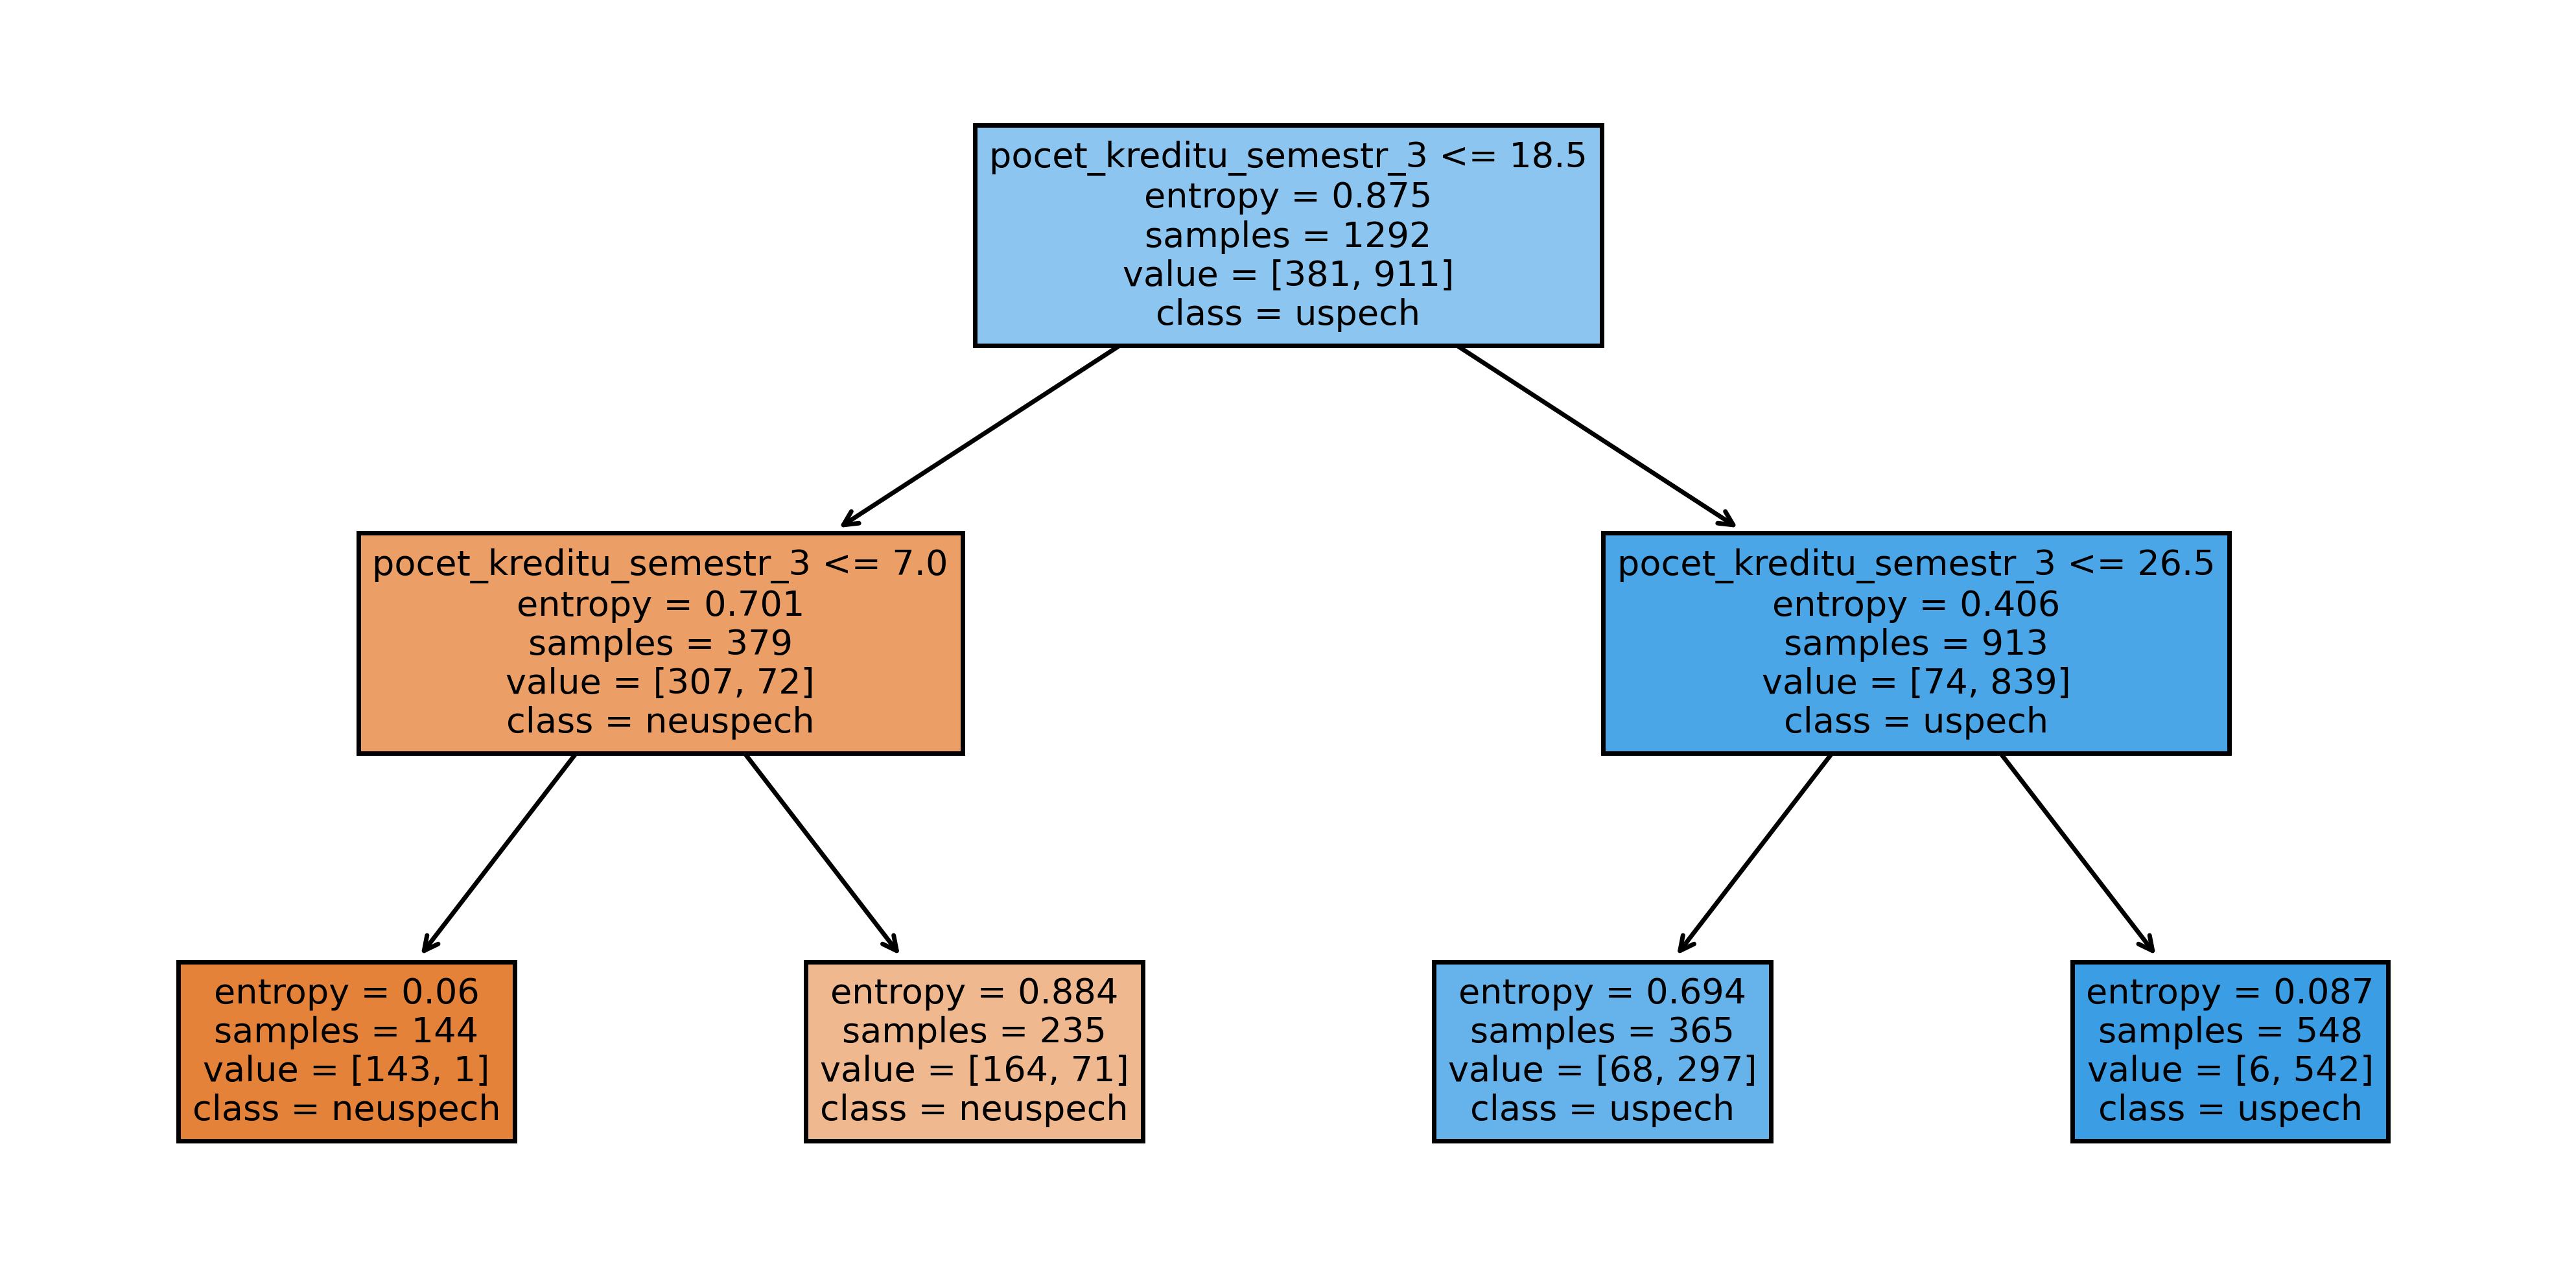

In [15]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_f1.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
path_file = os.sep.join(['decision_trees', 'tree_f1_semestr4.png'])
fig.savefig(path_file)

#### Random forest

In [16]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [17]:
rf_f1 = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}

0.908023 (+/-0.024780) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.908683 (+/-0.040620) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.907307 (+/-0.049774) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.919116 (+/-0.028364) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.912462 (+/-0.018601) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.908930 (+/-0.033674) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.907981 (+/-0.030543) for {'criterion': 'gini', 'max_depth': 2, 

In [18]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf_f1.predict(Xtest))))

accuracy score (train): 0.886997
accuracy score (test): 0.879630


In [19]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
28,pocet_kreditu_semestr_3,0.359110
22,BI-AAG_znamka,0.151571
24,BI-ZDM_znamka,0.102594
21,pocet_kreditu_semestr_2,0.074829
12,pocet_kreditu_semestr_1,0.058372
10,BI-ZMA_znamka,0.049499
23,BI-AAG_poradi_zapisu,0.042674
25,BI-ZDM_poradi_zapisu,0.039864
26,BI-AG1_znamka,0.025806
13,BI-PA2_znamka,0.021249


#### Adaboost

In [20]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [21]:
ab_f1 = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.30000000000000004, 'n_estimators': 35}

0.918645 (+/-0.029917) for {'learning_rate': 0.1, 'n_estimators': 5}
0.918645 (+/-0.029917) for {'learning_rate': 0.1, 'n_estimators': 10}
0.918645 (+/-0.029917) for {'learning_rate': 0.1, 'n_estimators': 15}
0.918645 (+/-0.029917) for {'learning_rate': 0.1, 'n_estimators': 20}
0.918148 (+/-0.030384) for {'learning_rate': 0.1, 'n_estimators': 25}
0.916985 (+/-0.028935) for {'learning_rate': 0.1, 'n_estimators': 30}
0.917625 (+/-0.031331) for {'learning_rate': 0.1, 'n_estimators': 35}
0.918122 (+/-0.030721) for {'learning_rate': 0.1, 'n_estimators': 40}
0.917512 (+/-0.030011) for {'learning_rate': 0.1, 'n_estimators': 45}
0.918986 (+/-0.030205) for {'learning_rate': 0.2, 'n_estimators': 5}
0.918573 (+/-0.029554) for {'learning_rate': 0.2, 'n_estimators': 10}
0.919136 (+/-0.031799) for {'learning_rate': 0.2, 'n_estimators': 15}
0.918078 (+/-0.031851) for {'learning_rate': 0.2, 'n_estimators': 20}
0.91

In [22]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab_f1.predict(Xtest))))

accuracy score (train): 0.891641
accuracy score (test): 0.873457


In [23]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
28,pocet_kreditu_semestr_3,0.400000
21,pocet_kreditu_semestr_2,0.142857
12,pocet_kreditu_semestr_1,0.085714
2,BI-PAI_znamka,0.057143
25,BI-ZDM_poradi_zapisu,0.057143
1,BI-PA1_poradi_zapisu,0.057143
13,BI-PA2_znamka,0.057143
26,BI-AG1_znamka,0.028571
23,BI-AAG_poradi_zapisu,0.028571
19,BI-LIN_znamka,0.028571


#### Xgboost

In [24]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [25]:
xgb_f1 = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.1, 'max_depth': 3}

0.917089 (+/-0.023641) for {'eta': 0.1, 'max_depth': 3}
0.916306 (+/-0.028775) for {'eta': 0.1, 'max_depth': 4}
0.914377 (+/-0.022677) for {'eta': 0.1, 'max_depth': 5}
0.909877 (+/-0.018785) for {'eta': 0.1, 'max_depth': 6}
0.911056 (+/-0.023320) for {'eta': 0.1, 'max_depth': 7}
0.909672 (+/-0.023761) for {'eta': 0.2, 'max_depth': 3}
0.911202 (+/-0.030962) for {'eta': 0.2, 'max_depth': 4}
0.910785 (+/-0.019475) for {'eta': 0.2, 'max_depth': 5}
0.905140 (+/-0.013647) for {'eta': 0.2, 'max_depth': 6}
0.913810 (+/-0.015864) for {'eta': 0.2, 'max_depth': 7}
0.910162 (+/-0.025586) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.908913 (+/-0.020619) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.906219 (+/-0.018182) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.905291 (+/-0.012791) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.907078 (+/-0.021511) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.908312 (+/-0.012058)

In [26]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb_f1.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest))))

accuracy score XGBoost (train): 0.928793
accuracy score XGBoost (val): 0.864198


In [27]:
feat_imp = pd.Series(xgb_f1.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [28]:
feat_imp

pocet_kreditu_semestr_3    133.0
pocet_kreditu_semestr_2     60.0
pocet_kreditu_semestr_1     45.0
BI-ZDM_znamka               36.0
BI-ZMA_znamka               34.0
BI-PA1_znamka               34.0
BI-PA2_znamka               33.0
BI-PAI_znamka               31.0
BI-DBS_znamka               23.0
BI-PS1_znamka               23.0
BI-AAG_poradi_zapisu        19.0
BI-CAO_znamka               19.0
BI-AG1_znamka               16.0
BI-MLO_znamka               15.0
BI-LIN_znamka               14.0
BI-PA1_poradi_zapisu        13.0
BI-AAG_znamka               10.0
BI-SAP_znamka                6.0
BI-ZMA_poradi_zapisu         6.0
BI-MLO_poradi_zapisu         4.0
BI-PS1_poradi_zapisu         2.0
BI-PAI_poradi_zapisu         2.0
BI-DBS_poradi_zapisu         1.0
dtype: float64

#### MLP

In [29]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

In [30]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (val): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.954334
accuracy score mlp (val): 0.867284


#### Lineární regrese

In [31]:
reg = LinearRegression().fit(Xtrain, ytrain)

In [32]:
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtrain), np.array(ytrain))))
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtest), np.array(ytest))))

RMSE reg (test): 0.293319562223885
RMSE reg (test): 0.300464495242155


#### kNN

In [33]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [34]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}

0.887485 (+/-0.021569) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.887485 (+/-0.021569) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.888346 (+/-0.022999) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.888346 (+/-0.022999) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.874359 (+/-0.028090) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.883982 (+/-0.027678) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.868273 (+/-0.016182) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.887616 (+/-0.023136) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.909030 (+/-0.012214) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.908361 (+/-0.013468) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.900356 (+/-0.016493) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.900118 (+/-0.017406) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.89

In [35]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (val): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.901703
accuracy score knn (val): 0.861111


## Výsledky

In [36]:
results = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

### Měřeno accuracy_score

In [37]:
results.loc['dt', 'vysledky'] = round(metrics.accuracy_score(ytest, dt_f1.predict(Xtest)), 3)
results.loc['rf', 'vysledky'] = round(metrics.accuracy_score(ytest, rf_f1.predict(Xtest)), 3)
results.loc['ab', 'vysledky'] = round(metrics.accuracy_score(ytest, ab_f1.predict(Xtest)), 3)
results.loc['xgb', 'vysledky'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest)), 3)
results.loc['mlp', 'vysledky'] = round(metrics.accuracy_score(ytest, mlp.predict(Xtest)), 3)
results.loc['knn', 'vysledky'] = round(metrics.accuracy_score(ytest, knn.predict(Xtest)), 3)

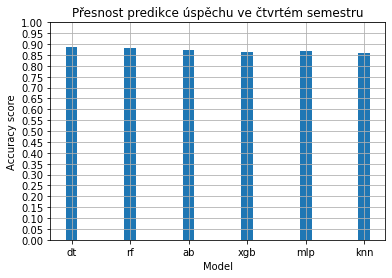

In [38]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results.index, results['vysledky'].values, width)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu ve čtvrtém semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

In [39]:
results

,vysledky
dt,0.886
rf,0.88
ab,0.873
xgb,0.864
mlp,0.867
knn,0.861


### Měřeno f1_score

In [40]:
results_f1 = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

In [41]:
results_f1.loc['dt', 'vysledky'] = round(metrics.f1_score(ytest, dt_f1.predict(Xtest)), 3)
results_f1.loc['rf', 'vysledky'] = round(metrics.f1_score(ytest, rf_f1.predict(Xtest)), 3)
results_f1.loc['ab', 'vysledky'] = round(metrics.f1_score(ytest, ab_f1.predict(Xtest)), 3)
results_f1.loc['xgb', 'vysledky'] = round(metrics.f1_score(ytest, xgb_f1.predict(Xtest)), 3)
results_f1.loc['mlp', 'vysledky'] = round(metrics.f1_score(ytest, mlp.predict(Xtest)), 3)
results_f1.loc['knn', 'vysledky'] = round(metrics.f1_score(ytest, knn.predict(Xtest)), 3)

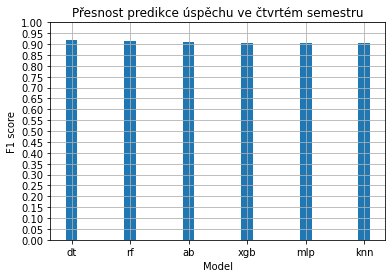

In [42]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results_f1.index, results_f1['vysledky'].values, width)

ax.set_ylabel('F1 score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu ve čtvrtém semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

In [43]:
results_f1

,vysledky
dt,0.92
rf,0.916
ab,0.911
xgb,0.904
mlp,0.906
knn,0.903
